In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time.core import Time, TimeDelta
from astropy.table import Table, vstack, hstack
import astropy.units as u
import numpy as np

In [6]:
hdulist = fits.open('../data/stix_sept_oct_21/solo_L1A_stix-sci-spectrogram-2109250032_20210925T190124-20210925T203726_021244_V01.fits')
header = hdulist[0].header
control = Table(hdulist[1].data)
data = Table(hdulist[2].data)
energies = Table(hdulist[3].data)

data_time = Time(header['date_obs']) + TimeDelta(data['time'] * u.s)

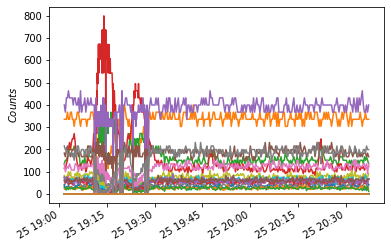

In [7]:
plt.plot_date(data_time.plot_date, data['counts'],'-')
plt.gcf().autofmt_xdate() 
plt.ylabel('$Counts$')
#plt.yscale('log')
plt.show()

In [8]:
#function to calculate live time 
eta = 2.5 * u.us
tau = 12.5 * u.us

def _lfrac(trigger_rate):
    nin = trigger_rate / (1 - (trigger_rate * (tau+eta)))
    return np.exp(-eta * nin) / (1 + tau * nin)

In [9]:
live_time = _lfrac(data['triggers'].reshape(-1)/(16*data['timedel']*u.s))
data_counts_per_sec = data['counts']/live_time.reshape(-1,1)

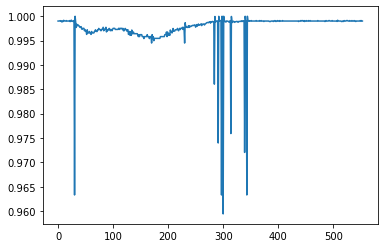

In [11]:
plt.plot(live_time)

In [46]:
#subtract background 
hdulist_bkg = fits.open('/Users/hannahcollier/Documents/solo/data/Oct_28_21_SEP_L1/bkg_solo_L1A_stix-sci-xray-l1-2110250047_20211025T080018-20211025T094018_017218_V01.fits')
data_bkg = Table(hdulist_bkg[2].data)
bkg_counts = np.reshape(np.sum(data_bkg['counts'],axis=(1,2))/data_bkg['timedel'],(32)) #sum over detectors & pixels and normalise by time bin duration
bkg_arr = []
for i in range(len(data)):
    bkg_arr.append(bkg_counts)
    
data_counts_per_sec_nobkg = data_counts_per_sec - bkg_arr 

In [47]:
#normalise by energy bin
energy_delta = energies['e_high']-energies['e_low']
data_counts_per_sec_per_keV = data_counts_per_sec_nobkg/energy_delta.reshape(1,-1)

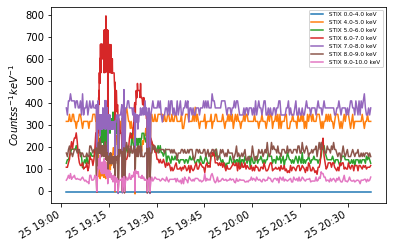

In [48]:
for i in range(len(energies)-25):
    plt.plot_date(data_time.plot_date, data_counts_per_sec_per_keV[:,i],'-', label=f' STIX {energies[i]["e_low"]}-{energies[i]["e_high"]} keV')
plt.gcf().autofmt_xdate() 
plt.ylabel('$Counts s^{-1}keV^{-1}$')
#plt.yscale('log')
plt.legend(fontsize = 'xx-small')
plt.show()